In [1]:
# Biblioteca
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import random
import math


# Gradiente Descendente

Capítulo 8, do livro Data Science do Zero de Joel Grus.

O autor usa o conceito de 'derivadas' para calcular Gradientes, Fundamentais para ajustar 'parâmetros e algorítimos de aprendizado de máquina'.

O quociente de diferenças é uma forma simples de derivar funções quando o cálculo analítico não está disponível.


### A ideia por trás do Gradiente Descendente

In [2]:
def square(v_i):
    """Calcula o quadrado de um número."""
    return v_i**2

def sum_of_squares(v):
    """Computa a soma dos elementos ao quadrado em v."""
    return sum(square(v_i) for v_i in v)

# Exemplo de uso
v = [1, 2, 3, 4]
print("Soma dos quadrados:", sum_of_squares(v))  # Saída esperada: 30

Soma dos quadrados: 30


### Estimando o Gradiente

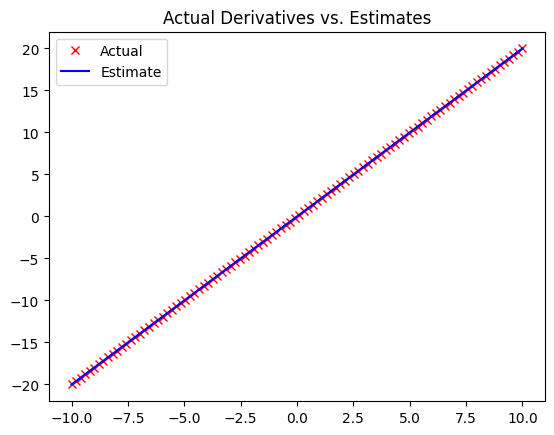

In [3]:
# Definindo a função quadrática
def square(x):
    return x ** 2

# Derivada real da função quadrática
def derivative(x):
    return 2 * x

# Função para diferença quociente
def difference_quotient(f, x, h):
    return (f(x + h) - f(x)) / h

# Aproximação da derivada usando diferença quociente
derivative_estimate = partial(difference_quotient, square, h=0.00001)

# Valores para o gráfico
# x = range(-10,100)
x = np.linspace(-10, 10, 100)  # Convertendo para array contínuo
actual = [derivative(xi) for xi in x]  # Derivada real 
estimate = [derivative_estimate(xi) for xi in x]    # Aproximação

# Plotando os resultados
plt.title("Actual Derivatives vs. Estimates")
plt.plot(x, actual, 'rx', label='Actual')   # vermelho x
plt.plot(x, estimate, 'b-', label='Estimate')   #azul (linha)
#plt.plot(x, map(derivative, x), 'rx', label='Actual')               # vermelho x
#plt.plot(x, map(derivative_estimate, x), 'b+', label='Estimate')    # Azul +
plt.legend(loc=0)
plt.show()


Quando 'f' é uma função de muitas variáveis, possui múltiplas derivadas parciais, cada uma indicando como 'f' muda quando fazermos pequenas mudanças em apenas uma das variáveis de entrada. Calculamos sua derivada parcial i-ésimo ao tratá-la como uma função de apenas a i-ésima variável, contendo as outras variáveis fixas:

In [4]:
def partial_difference_quotient(f,v,i,h):
    """computa o i-ésimo quociente diferencial parcial de f em v"""
    w = [v_j + (h if j == i else 0) #adiciona h ao elemento i-ésimo de v
         for j, v_j in enumerate(v)]
    
# depois do que podemos estimar o gradiente do mesmo jeito:
def estimate_gradient(f,v,h=0.00001):
    return [partial_difference_quotient(f,v,i,h)
            for i, _ in enumerate(v)]

### Usando o Gradiente


É fácil ver que a função 'sum_of_squares' tem seu mínimo valor quando sua entrada "v" é um vetor de zeros. Mas imagine que não soubéssemos disso. Usaremos os gradientes para encontrar o mínimo entre todos os vetores tridimensionais. Pegaremos um ponto inicial aleatório e andaremos pequenos passos na direção oposta do gradiente, até  chegarmos em um ponto em que o gradiente seja muito pequeno:

In [ ]:
def distance(v1, v2):
    """Calcula a distância Euclidiana entre dois vetores."""
    return math.sqrt(sum((x - y) ** 2 for x, y in zip(v1, v2)))

def step(v, direction, step_size):
    """move step_size na direção a partir de v"""
    return [v_i + step_size*direction_i
            for v_i, direction_i in zip(v, direction)]

def sum_of_squares_gradient(v):
    return [2*v_i for v_i in v]

# Função para ajustar o vetor
def step(v, gradient, step_size):
    return [v_i + step_size * g_i for v_i, g_i in zip(v, gradient)]

# escolhe um ponto inicial aleatório
v = [random.randint(-10,10) for i in range(3)]
tolerance = 0.0000001

while True:
    gradient = sum_of_squares_gradient(v)   # computa o gradiente em v
    next_v = step(v,gradient, -0.01)    # pega um passo gradiente negativo
3    if distance(next_v, v)<tolerance:   # para se estivermos convergindo
        break
    v = next_v                      # continua se não estivermos
print ("Ponto de convergência:", v)

Ponto de convergência: [4.700160682777249e-06, -1.0444801517282768e-06, -1.0444801517282768e-06]


Codificando, percebemos que esta última parte sempre termina com um "v" muito próximo a [0,0,0]. Quanto menor for a 'tolerance', mais próximo estes parâmetros seram.

### Escolhendo o tamanho do próximo passo

Embora a lógica de se mover em direção ao gradiente esteja clara, a distância não está. De fato, escolher o tamanho do próximo passo é mais uma arte do que uma ciência. As opções mais populares são:
- Usar um passo de tamanho fixo;
- Diminuir gradualmente o tamanho do passo a cada vez;
- A cada passo, escolher o tamanho do passo que minimize o valor da função objetiva.

É possível que determinados tamanhos de passos resultarão em entradas inválidas para nossa função. Então, vc precisará criar uma função "aplicação segura" que retorna infinito (que nunca deveria ser o mínimo de nada) para entradas inválidas:

In [6]:
def safe(f):
    """retorna uma nova função que é igual a f,
    exceto quando ele exiba infinito como saída toda vez que f produz um erro"""
    def safe_f(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except:
            return float('inf')     # isso significa "infinito" em Python
    return safe_f

### Juntando tudo

No geral, temos alguma 'target_fn' que queremos minimizar, e também temos o seu 'gradient_fn'. Por exemplo, 'targe_fn' poderia representar erros em um modelo como uma função dos seus parâmetros, e talvez queiramos encontrar os parâmetros que produzem os menores erros possíveis.

Além do mais, digamos que escolhemos um valor inicial para os parâmetros 'theta_0'. Logo, podemos implementar o gradiente descendente como:

In [9]:
def minimize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    """Usa o gradiente descendente para encontrar theta que minimize a função alvo."""
    step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
    theta = theta_0  # Ajusta theta para o valor inicial
    target_fn = safe(target_fn)  # Versão segura de target_fn
    value = target_fn(theta)  # Valor que estamos minimizando

    while True:
        gradient = gradient_fn(theta)
        # Gera novos candidatos para theta
        next_thetas = [step(theta, gradient, -step_size) for step_size in step_sizes]
        # Escolhe o theta que minimiza a função de erro
        next_theta = min(next_thetas, key=target_fn)
        next_value = target_fn(next_theta)

        # Para se estivermos "convergindo"
        if abs(value - next_value) < tolerance:
            return theta
        else:
            theta, value = next_theta, next_value


Chamamos de 'minimize_batch' porque, para cada passo do gradiente, ele considera o conjunto inteiro de dados (devido ao 'target_fn' retornar o erro no conjunto de dados inteiro).

Às vezes vamos querer maximizar uma função e podemos fazê-lo ao minimizar seu negativo (que possui um gradiente negativo correspondente):

In [11]:
def negate(f):
    """retorna uma função que, para qualquer entrada, x retorna -f(x)"""
    return lambda *args, **kwargs: -f(*args, **kwargs)

def negate_all(f):
    """o mesmo quando f retorna uma lista de números"""
    return lambda *args, **kwargs: [-y for y in f(*args, **kwargs)]

def maximize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    return minimize_batch(negate(target_fn), negate_all(gradient_fn), theta_0, tolerance)

### Gradiente descendente estocástico

Ao usar o grupo de abordagens anteriores, cada passo gradiente requer que nós façamos uma previsão e computemos o gradiente para o conjunto de dados inteiro fazendo com que cada passo levasse mais tempo.

Normalmente, essas funções de erro são aditivas, o que significa que o erro previsto no conjunto de dados inteiro seja simplesmente a soma dos erros preditivos para cada ponto.

Quando é este o caso, podemos aplicar uma técnica chamada gradiente descendente estocástico, que computa o gradiente (e anda um passo) apenas um ponto de cada vez. Ele circula sobre nossos dados repetidamente até alcançar um ponto de parada. Durante cada ciclo, vamos querer iterar sobre nossos dados em ordem aleatória:

In [14]:
def in_random_order(data):
    """gerador retorna os elementos do dado em ordem aleatória"""
    indexes = [i for i,_ in enumerate(data)] # cria uma lista de índices
    random.shuffle(indexes) # os embaralha
    for i in indexes:   # retorna os dados naquela ordem
        yield data[i]

Andaremos um passo gradiente para cada ponto de dados. Esse método deixa a possibilidade de circularmos próximos a um mínimo para sempre, então quando pararmos de obter melhorias, diminuiremos o tamanho do passo e, eventualmente, pararemos:

In [16]:
def minimize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    data = zip(x,y)
    theta = theta_0         # palpite inicial
    alpha = alpha_0         # tamanho do passo inicial
    min_theta, min_value = None, float("inf")       # o mínimo até agora
    iterations_with_no_improvement = 0

# se formos até 100 iterações sem melhorias, paramos 

    while iterations_with_no_improvement < 100:
        value = sum(target_fn(x_i,y_i, theta) for x_i,y_i in data)

    if value < min_value:

        # se achou um novo mínimo, lembre-se
        # e volte para o tamanho do passo original

        min_theta, min_value = theta, value
        iterations_with_no_improvement = 0
        alpha *= 0.9

# e ande um passo gradiente para todos os pontos de dados

    for x_i, y_i in in_random_order(data):
        gradient_i = gradient_fn(x_i,y_i, theta)
        theta = vector_subtract(theta)

    return min_theta


A versão estocástica será tipicamente mais rápida do que a versão batch. Naturalmente, vamos querer uma versão que maximize da mesma forma:

In [17]:
def maximize_stochastic(target_fn, gradiente_fn, x,y, theta_0, alpha_0=0.01):
    return minimize_stochastic(negate(target_fn), negate_all(gradiente_fn), x,y, theta_0, alpha_0)

### Explicação sobre Gradiente Descendente Estocástico (SGD)
O Gradiente Descendente Estocástico (SGD) é uma variante do gradiente descendente tradicional, que utiliza apenas uma ou um pequeno subconjunto de amostras (batch) para calcular o gradiente em vez de usar todo o conjunto de dados. Isso reduz o custo computacional por iteração e pode ajudar a escapar de mínimos locais em funções complexas.

### Etapas do SGD:
1. Escolha aleatória de uma amostra ou minibatch.
2. Cálculo do gradiente da função objetivo com relação aos parâmetros.
3. Atualização dos parâmetros na direção negativa do gradiente (minimização).
4. Repetição até convergência.

### Vantagens:

- Mais rápido em datasets grandes.
- Introduz ruído que pode ajudar a escapar de mínimos locais.

### Desvantagens:

- Pode levar mais tempo para convergir, pois as atualizações são mais ruidosas.
- Oscilações ao redor do mínimo podem ocorrer.

### Proposta para Visualizar o Processo

1. Convergência da Função Objetivo:
Gráfico mostrando a evolução do valor da função objetivo ao longo das iterações.

2. Trajetória do Gradiente:
Gráfico 2D ou 3D para observar a trajetória da otimização na superfície da função.

3. Taxa de Aprendizado:
Gráfico comparativo para diferentes taxas de aprendizado, ilustrando como elas afetam a convergência.

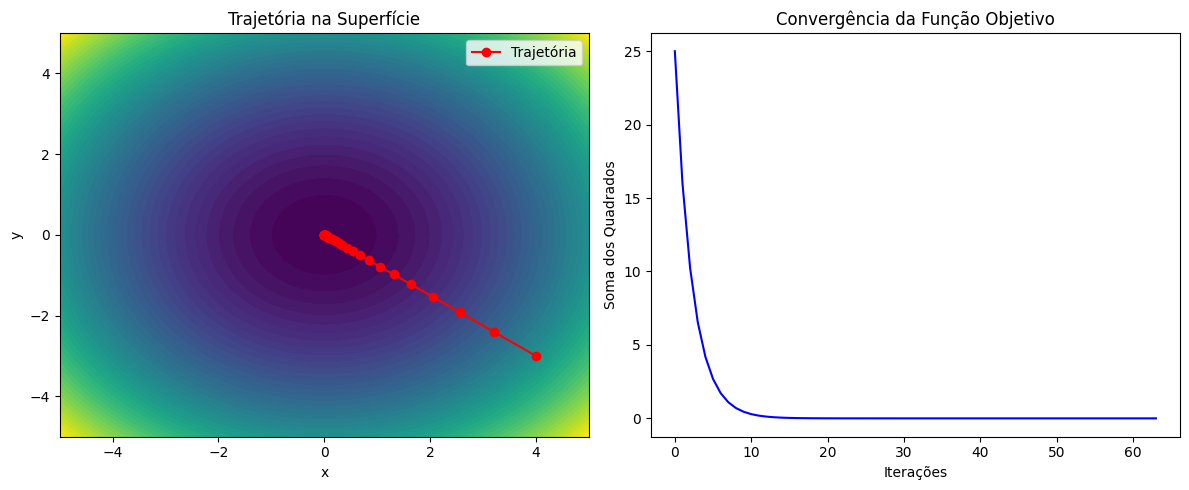

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Função Soma dos Quadrados
def square(v_i):
    """Calcula o quadrado de um número."""
    return v_i ** 2

def sum_of_squares(v):
    """Computa a soma dos elementos ao quadrado em v."""
    return sum(square(v_i) for v_i in v)

# Gradiente da função soma dos quadrados
def sum_of_squares_gradient(v):
    """Calcula o gradiente da soma dos quadrados."""
    return [2 * v_i for v_i in v]

# Gradiente Descendente Estocástico
def gradient_descent(start, gradient_fn, step_size, tolerance=1e-6, max_iters=1000):
    """Executa o gradiente descendente."""
    v = start
    path = [v]  # Para rastrear a trajetória
    for _ in range(max_iters):
        gradient = gradient_fn(v)
        next_v = [v_i - step_size * grad_i for v_i, grad_i in zip(v, gradient)]
        path.append(next_v)
        if np.linalg.norm(np.array(next_v) - np.array(v)) < tolerance:
            break
        v = next_v
    return v, path

# Configuração inicial
start = [4, -3]  # Ponto inicial
step_size = 0.1  # Tamanho do passo
tolerance = 1e-6

# Executar o gradiente descendente
_, path = gradient_descent(start, sum_of_squares_gradient, step_size, tolerance)

# Trajetória e Gráficos
path = np.array(path)
x_vals, y_vals = path[:, 0], path[:, 1]

# Criar os gráficos
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Trajetória na superfície
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = X**2 + Y**2
ax[0].contourf(X, Y, Z, levels=50, cmap="viridis")
ax[0].plot(x_vals, y_vals, 'r-o', label="Trajetória")
ax[0].set_title("Trajetória na Superfície")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].legend()

# Convergência da Função Objetivo
objective_values = [sum_of_squares(p) for p in path]
ax[1].plot(range(len(objective_values)), objective_values, 'b-')
ax[1].set_title("Convergência da Função Objetivo")
ax[1].set_xlabel("Iterações")
ax[1].set_ylabel("Soma dos Quadrados")

plt.tight_layout()
plt.show()


Os gráficos mostram o processo de gradiente descendente:

1. Trajetória na Superfície: A trajetória do ponto inicial até o mínimo é mostrada em vermelho. Esse gráfico destaca como o gradiente descendente "desce" pela superfície da função objetivo.

2. Convergência da Função Objetivo: O gráfico à direita mostra a diminuição da soma dos quadrados ao longo das iterações, ilustrando como o algoritmo se aproxima do mínimo.

### Conclusão

Ao longo deste estudo, exploramos a aplicação do gradiente descendente como uma ferramenta poderosa para otimização. Por meio de análises práticas e visuais, ficou evidente como esse método guia a busca por soluções minimizando funções objetivo. Os resultados destacaram não apenas a eficiência da abordagem, mas também sua adaptabilidade em diferentes cenários.

Embora o gradiente descendente seja amplamente utilizado, ele também exige escolhas criteriosas, como o tamanho do passo e condições de convergência, que impactam diretamente nos resultados. Esse trabalho reforça a importância de compreender os fundamentos matemáticos e computacionais para aplicá-los de forma eficaz em problemas reais.

Em suma, este estudo não só demonstrou a utilidade do gradiente descendente, mas também abriu caminho para aplicações futuras em áreas que demandam soluções rápidas e precisas, como ciência de dados, inteligência artificial e engenharia.

### Bibliografia

Boelkins, M. (2022). Active Calculus. Whitman College. Disponível em: https://activecalculus.org.

Grus, J. (2019). Data Science do Zero: Primeiras Regras com o Python. O'Reilly Media.

Goodfellow, I., Bengio, Y., & Courville, A. (2016). Deep Learning. MIT Press.

Nocedal, J., & Wright, S. (2006). Numerical Optimization. Springer Science & Business Media.